# Demo on data preprocessing and postprecessing pipeline

**The purpose of this demo is to show how to use `data_loader` and `postprocessing` function.** Here we use a pretrained Unet as example model.

## Load dependency

In [1]:
import sys

%load_ext autoreload
%autoreload 2
      
sys.path.append('../')

import torch
from dataset import data_loaders, BrainSegmentationDataset
from utils import postprocess_per_volume, dsc_distribution, plot_dsc, gray2rgb, outline
from skimage.io import imsave, imshow
import numpy as np
from matplotlib import pyplot as plt

from models.unet import UNet

## Use `data_loaders` to get dataloaders for training and validation set

Below we use the default argument. `data_loader()` will automatically load default settings for you. It should take 10-20 minutes to finish loading full dataset (i.e. setting `valid_only` argument as False).

If we only need validation set, we can set `valid_only=True`, which will take 1-2 minutes to finish.



In [2]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

batch_size = 16
epochs = 50
lr = 0.0001
workers = 2
weights = "./"
image_size = 224
aug_scale = 0.05
aug_angle = 15

_, loader_valid = data_loaders(batch_size, workers, image_size, aug_scale, aug_angle, path="../kaggle_3m", valid_only=True)

reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
done creating validation dataset


## Load a pretrained Unet

In [3]:

unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
state_dict = torch.load('../weights/unet.pt', map_location=device)
unet.load_state_dict(state_dict)
unet.eval()
unet.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## Evaluate Unet on `loader_vaild`

Important shapes:

x: (16, 3, 224, 224), where 3 is channel number

y_true: (16, 1, 224, 224)

16 is default batch size, which can be manipulated by `batch_size` argument in `data_loaders` function.


**Notice that the range of y_true entry is [0, 255]**, where 0 is background (black), 255 is mask (white, groundtruth)

In [4]:

input_list = []
pred_list = []
true_list = []

for i, data in enumerate(loader_valid):
    x, y_true = data
    x, y_true = x.to(device), y_true.to(device)
    
    with torch.set_grad_enabled(False):
        y_pred = unet(x)
        y_pred_np = y_pred.detach().cpu().numpy()
        pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])
        y_true_np = y_true.detach().cpu().numpy()
        true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])
        x_np = x.detach().cpu().numpy()
        input_list.extend([x_np[s] for s in range(x_np.shape[0])])


## Postprocess the output

In [5]:
print(f"{pred_list[0].shape=}")

volumes = postprocess_per_volume(
        input_list,
        pred_list,
        true_list,
        loader_valid.dataset.patient_slice_index,
        loader_valid.dataset.patients,
    )

pred_list[0].shape=(1, 224, 224)


## `volumes` explanation

`volumes` is a dictionary with patient name as key

Each entry is a tuple with size 3. The three entries are original image (`x`), predicted mask (`y_pred`) and true mask (`y_true`) respectively.

In [6]:
print(f"{volumes.keys() = }")
print(f"{volumes['TCGA_HT_7616_19940813'][0].shape = }")
print(f"{volumes['TCGA_HT_7616_19940813'][1].shape = }")
print(f"{volumes['TCGA_HT_7616_19940813'][2].shape = }")

volumes.keys() = dict_keys(['TCGA_HT_7616_19940813', 'TCGA_CS_6668_20011025', 'TCGA_CS_4944_20010208', 'TCGA_HT_7879_19981009', 'TCGA_DU_7014_19860618', 'TCGA_DU_6408_19860521', 'TCGA_DU_6404_19850629', 'TCGA_DU_5851_19950428', 'TCGA_CS_6667_20011105', 'TCGA_HT_7692_19960724'])
volumes['TCGA_HT_7616_19940813'][0].shape = (28, 3, 224, 224)
volumes['TCGA_HT_7616_19940813'][1].shape = (28, 1, 224, 224)
volumes['TCGA_HT_7616_19940813'][2].shape = (28, 1, 224, 224)


## Plot outputs

The red outline is the prediction and green outline is groundtruth.

**Range of y_true is [0, 255], so we need to use `y_true[s, 0]/255` to draw the outline.**

TCGA_HT_7616_19940813


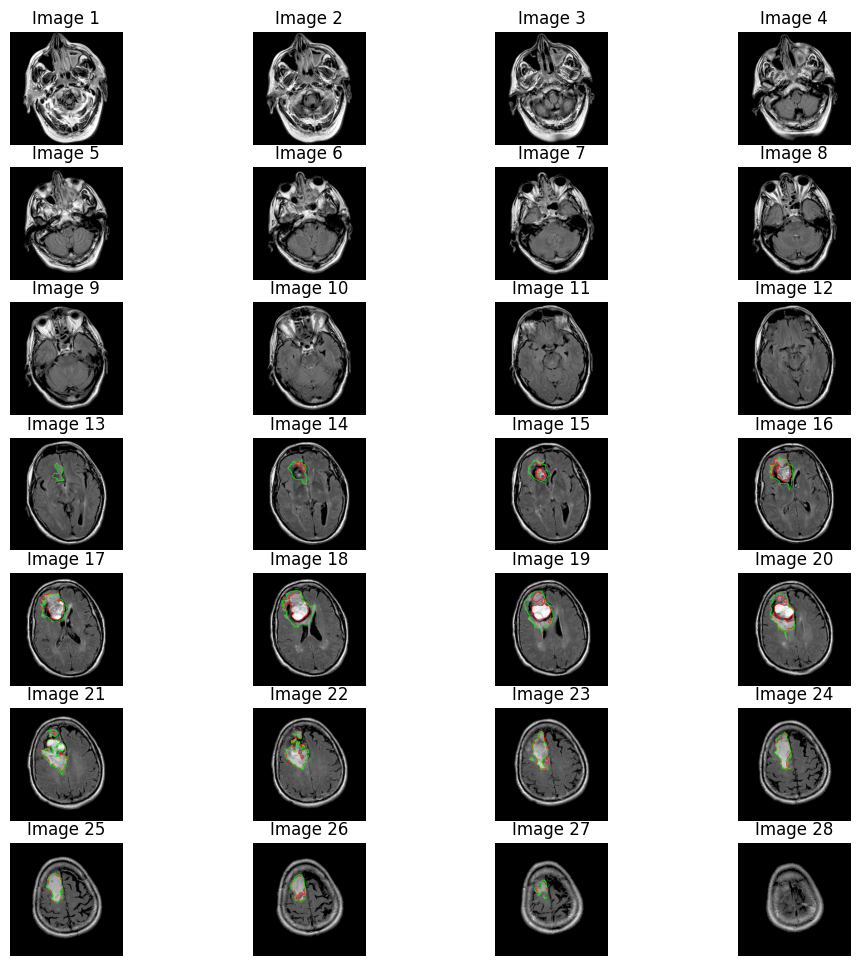

In [21]:
dem = 4

for p in volumes:
    print(p)
    x = volumes[p][0]
    y_pred = volumes[p][1]
    y_true = volumes[p][2]
    fig, axs = plt.subplots(nrows=int(x.shape[0]/dem), ncols=dem, figsize=(12, 12))

    for s in range(x.shape[0]):
        image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR
        image = outline(image, y_pred[s, 0], color=[255, 0, 0])
        image = outline(image, y_true[s, 0]/255, color=[0, 255, 0])
        axs[int(s/dem), s%dem].imshow(image)
        axs[int(s/dem), s%dem].set_title(f"Image {s+1}")
        axs[int(s/dem), s%dem].axis('off')

        # for a single column
        # axs[int(s/dem)].imshow(image)
        # axs[int(s/dem)].set_title(f"Image {s+1}")
        # axs[int(s/dem)].axis('off')


    # plt.tight_layout()
    plt.show()

    break
    

## plot dsc distribution

`dsc` and `dsc_distribution` are defined in `utils.py`.

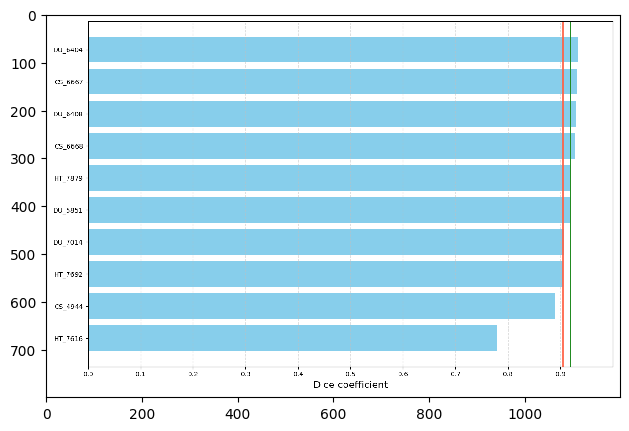

In [ ]:
dsc_dist = dsc_distribution(volumes)

dsc_dist_plot = plot_dsc(dsc_dist)

imshow(dsc_dist_plot)

plt.show()

## Mean dice similarity coefficient for Unet

In [ ]:
dsc_dist

{'TCGA_HT_7616_19940813': 0.7797159867491371,
 'TCGA_CS_6668_20011025': 0.9283062453592937,
 'TCGA_CS_4944_20010208': 0.889828088411674,
 'TCGA_HT_7879_19981009': 0.919727357426568,
 'TCGA_DU_7014_19860618': 0.9069054960113542,
 'TCGA_DU_6408_19860521': 0.930175097831986,
 'TCGA_DU_6404_19850629': 0.9342842256089618,
 'TCGA_DU_5851_19950428': 0.9180526156637435,
 'TCGA_CS_6667_20011105': 0.9324573706355651,
 'TCGA_HT_7692_19960724': 0.9056179775280899}

In [ ]:
print(sum(dsc_dist.values())/len(dsc_dist))


0.9045070461226373
